<a href="https://colab.research.google.com/github/Kunalthebug/Deep-Learning/blob/master/Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#accessing Kaggle Dataset
!pip install kaggle
#Math operations
!pip install numpy
#for ML
!pip install catboost

     |████████████████████████████████| 61.2MB 1.1MB/s 


In [0]:
#Data preprocessing
import pandas as pd
#math operations
import numpy as np
#Machine Leatning
from catboost import CatBoostRegressor,Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
#support vector machine modl
from sklearn.svm import NuSVR,SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#Data Visualization
import matplotlib.pyplot as plt


In [0]:
#colab's  file access feature
from google.colab import files
#retrieving uploaded files 
uploaded=files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [0]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3095           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11463           False  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4570           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         45           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3544           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [0]:
!kaggle competitions download -c LANL-Earthquake-Prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
train=pd.read_csv("train.csv",nrows=60000000,dtype={'Acoustic_data': np.int16,'time_to_failure': np.float64})

In [0]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


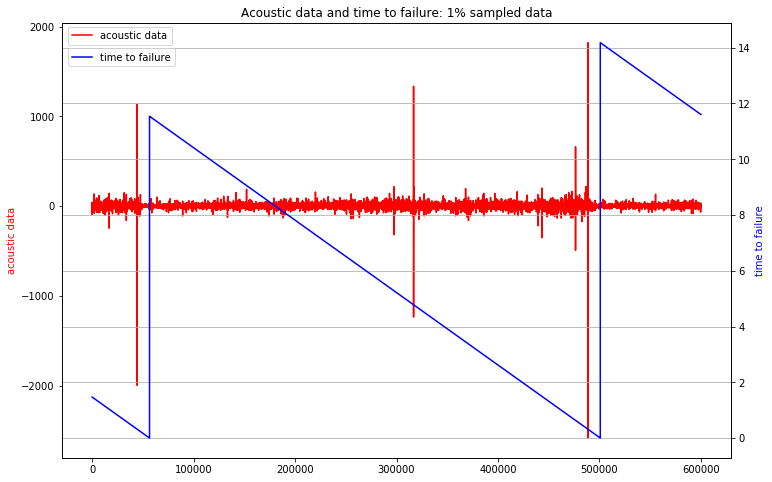

In [0]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df
                      

In [0]:
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train.describe()


,acoustic_data,time_to_failure
count,6.000000e+07,6.000000e+07
mean,4.518558e+00,6.472908e+00
std,1.192783e+01,4.313729e+00
min,-4.621000e+03,6.954822e-04
25%,2.000000e+00,2.427696e+00
50%,5.000000e+00,6.323996e+00
75%,7.000000e+00,1.022030e+01
max,3.914000e+03,1.418060e+01


In [0]:
X_train=pd.DataFrame()
Y_train=pd.Series()

In [0]:

train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
  

In [0]:
X_train.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000,1832.000000
mean,4.584514,6.535917,-147.475983,163.593341,66.496570,0.121375,-11.160529,-2.101583,11.260398,20.385453,169.812773,5.592114,5.744968
std,0.255368,8.580853,257.897906,292.984282,68.758229,0.488297,14.791871,2.318095,2.390894,14.948040,307.992014,1.517581,8.417387
min,3.798020,2.802720,-4621.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.256987,2.626497
25%,4.401910,4.453737,-151.000000,91.000000,27.683746,-0.037895,-13.000000,-3.000000,10.000000,15.000000,93.000000,5.069005,3.848382
50%,4.581937,5.571307,-109.000000,122.000000,45.185811,0.084559,-10.000000,-2.000000,11.000000,19.000000,126.000000,5.415610,4.743067
75%,4.760558,6.822690,-79.000000,167.250000,77.083625,0.252085,-6.000000,-1.000000,12.000000,22.000000,172.000000,5.820858,5.835820
max,5.391993,142.976883,-15.000000,5444.000000,625.540341,3.881835,-2.000000,0.000000,50.000000,337.000000,5444.000000,32.762073,140.105751


In [0]:
train_pool=Pool(X_train,y_train)
m=CatBoostRegressor(iterations=10000,loss_function='MAE',boosting_type='Ordered')
m.fit(X_train,y_train,silent=True)
m.best_score_

{'learn': {'MAE': 1.7041482719171055}}

In [0]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
parameters=[{'gamma':[0.001,0.005,0.01,0.02,0.05,0.1],
            'C':[0.1,0.2,0.25,0.5,1,1.5,2]}]
regl=GridSearchCV(SVR(kernel='rbf',tol=0.01),parameters,cv=5,scoring='neg_mean_absolute_error')
regl.fit(X_train_scaled,y_train.values.flatten())
y_predl=regl.predict(X_train_scaled)
print("Best CV score:{:.4f}".format(regl.best_score_))
print(regl.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best CV score:-2.8467
{'C': 2, 'gamma': 0.02}
